In [1]:
# IMPORT ALL LIB 
import subprocess
import numpy as np  
import matplotlib.pyplot as plt 

#%pip install pyvisa
#%pip install pyvisa-py
import pyvisa  
print("pyvisa==",pyvisa.__version__)

pyvisa== 1.15.0


In [2]:
# The IP of the PC 
result = subprocess.run(["ipconfig"], capture_output=True, text=True)
output =result.stdout
arr=output.split("\n")
for i,l in enumerate (arr):
    if "Ethernet adapter Ethernet:" in l:
        break
for j in range(i,i+7):
    l= arr[j]
    print(l)

Ethernet adapter Ethernet:

   Connection-specific DNS Suffix  . : 
   Link-local IPv6 Address . . . . . : fe80::5481:6a10:a56d:aec%18
   Autoconfiguration IPv4 Address. . : 169.254.104.97
   Subnet Mask . . . . . . . . . . . : 255.255.0.0
   Default Gateway . . . . . . . . . : 


In [3]:
scope_ip = "169.254.104.98" 

In [4]:


def ping_oscilloscope(ip="169.254.229.238", count=1):
    try:
        result = subprocess.run(
            ["ping", "-n", str(count), ip],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,  # decode output as text
            shell=True
        )
        if result.returncode == 0:
            print("Ping successful:")
        else:
            print("Ping failed:")
        print(result.stdout)
    except Exception as e:
        print("Error pinging oscilloscope:", e)

ping_oscilloscope(ip = scope_ip )

Ping successful:

Pinging 169.254.104.98 with 32 bytes of data:
Reply from 169.254.104.98: bytes=32 time=1ms TTL=255

Ping statistics for 169.254.104.98:
    Packets: Sent = 1, Received = 1, Lost = 0 (0% loss),
Approximate round trip times in milli-seconds:
    Minimum = 1ms, Maximum = 1ms, Average = 1ms



In [5]:
rm = pyvisa.ResourceManager('@py') # Use pyvisa-py backend  

 
resource_str = f"TCPIP::{scope_ip}::INSTR"  
try:  
    scope.close()  
except: pass  
try:  
    scope = rm.open_resource(resource_str)  
    print("Connected to:", scope.query("*IDN?"))  
except Exception as e:  
    print("Connection failed:", e)  

Connected to: TEKTRONIX,TDS 3034B,0,CF:91.1CT FV:v3.35 TDS3FFT:v1.00 TDS3TRG:v1.00



In [6]:
def det_data(chanel = "CH1"): 
    scope.write("DATA:SOURCE "+chanel)  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    
    # Read waveform settings for scaling  
    x_increment = float(scope.query("WFMPRE:XINCR?"))  
    x_origin = float(scope.query("WFMPRE:XZERO?"))  
    y_increment = float(scope.query("WFMPRE:YMULT?"))  
    y_origin = float(scope.query("WFMPRE:YZERO?"))  
    y_offset = float(scope.query("WFMPRE:YOFF?"))  
    
    
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000")  
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    
    # Scale data  
    voltages = (wave - y_offset) * y_increment + y_origin  
    
    times = np.arange(len(voltages)) * x_increment + x_origin 
    return times, voltages
#det_data(chanel = "CH1")

In [7]:
def get_active_channels():
    active_channels = []
    for i in range(1, 5):  # assuming up to CH4
        try:
            response = scope.query(f"SELECT:CH{i}?").strip()
            if response in ['1', 'ON']:  # depending on oscilloscope
                active_channels.append(f"CH{i}")
        except Exception as e:
            print(f"Error querying CH{i}: {e}")
    return active_channels
chanels = get_active_channels()
#chanels

In [8]:
#chanels = ['CH1', 'CH2']
def get_probe_config(chanels): 
    #params = ["PROBe", "IMPEDANCE", "COUPLING"]
    params = ["PROBe", "IMPEDANCE", "COUPLING", 
              "OFFSET", "POSITION", "BANDWIDTH", "INVERT", "SCALE"]
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        for p in params: 
            try:
                dic[p]= scope.query(cu+":"+p+"?").replace("\n", "")
            except: pass
        DIC[c]= dic
    params = ["HORIZONTAL:MAIN:SCALE?", "WFMPRE:NR_Pt?"]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["general"]= dic


    params = [
        "TRIGger:STATE?",
        "TRIGger:MAIn:EDGE:SOURce?",
        "TRIGger:MAIn:EDGE:SLOPe?",
        "TRIGger:MAIn:EDGE:COUPling?",
        "TRIGger:MAIn:LEVel?"
    ]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["trigger"]= dic
    
    return DIC
#get_probe_config(chanels)

In [9]:
def get_meas():
    arr = {}
    for i in range(1,5):  
        data, status = scope.query(f"MEASurement:MEAS{i}:DATA?").split(',')  
        mtype = scope.query(f"MEASurement:MEAS{i}:TYPE?").strip()
        source = scope.query(f"MEASurement:MEAS{i}:SOURCE1?").strip()
        if int(status) ==0:  
            #print("#", source,mtype, data)  
            try:
                arr[source][mtype]=data
            except:
                arr[source] = {mtype:data}

    return arr
#get_meas()              

In [10]:
import json


def get_params_txt(title=None):
    chanels = get_active_channels()
    dic  =get_probe_config(chanels)
    dic["measurements"]= get_meas() 
    if title is not None: 
        # Save to JSON file
        with open(title+".json", "w") as f:
            json.dump(dic, f, indent=4)
    return dic 
#_= get_params_txt("test")
#_

In [11]:
import pandas as pd 
def get_signals(title):
    chanels = get_active_channels()
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        time, voltage = det_data(chanel = cu)
        DIC["time"]= time
        DIC[cu]= voltage
    df = pd.DataFrame(DIC)
    df.to_csv(title+".csv", index = False) 
    return df


# MEAS

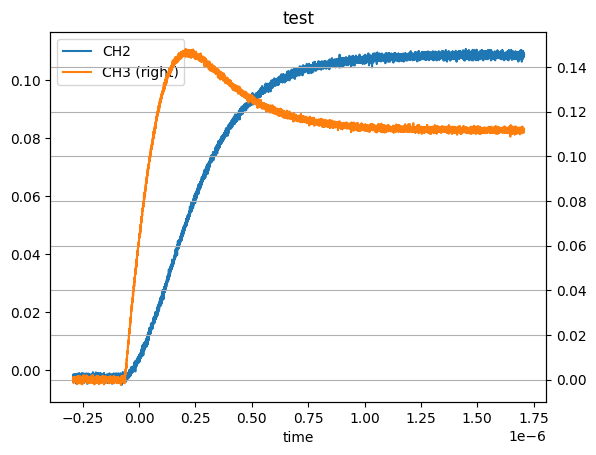

In [12]:
#read all chanels, parameters in one cmd 
title = "test"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

In [14]:
df.to_csv("L_meas.csv")